# 5TF078 Deep Learning Course
## Excercise 2 Transfer Learning on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-04-01 First revision based on earlier excercises /ToNo

## **Erik Vodopivec Forsman**

# First we initilize our Python environment

In [1]:
#### Set up tests to know if we are running Colab or Kaggle
import sys

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [2]:
# Set up Keras/Tensorflow framework
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # Also tensorflow, jax,pytorch for Keras 3.0

import keras
print('Keras version:', keras.__version__)

# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

Keras version: 2.15.0
TensorFlow version: 2.15.0


In [3]:
#### Additional helper libraries
import pandas as pd
import numpy as np
import time
import sklearn
import tensorflow_datasets as tfds

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

In [4]:
#### Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     if IS_COLAB or IS_KAGGLE:
         print("Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-29429420-c2eb-0f35-39f4-ab7f3bd4b0a3)


# Set up the needed data sets, its preprocessing, and making it into a stream.

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [5]:
#### Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

# Normalise images to a float between 0 and 1
train_images0 = train_images0.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Add empty color dimensions to images
train_images0 = np.expand_dims(train_images0, -1)
test_images = np.expand_dims(test_images, -1)

4422102/4422102 [==============================] - 1s 0us/step


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach will be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `keras.utils.to_categorical(train_labels)`. This was used in Excercise 1.

In this Excercise we will achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). But note that for both cases we need our model to have as many output nodes as we have classes!

## Set up the streaming of data

In [6]:
#### Function to reformat data so that we can use a predefined network

# Later you will find out what is the minumum size
##################### TODO: MIGHT NEED AN UPDATE #####################
NEWIMG_WIDTH = 56*3
NEWIMG_HEIGHT = 56*3

# Define an in-stream transform function (normalize, add color-dim, gray2color, resize)
def ds_img_transform(images,labels):
    ##################### TODO: YOUR CODE STARTS HERE #####################
    images = tf.image.grayscale_to_rgb(images) # convert to rgb
    images = tf.image.resize_with_pad(images, NEWIMG_HEIGHT, NEWIMG_WIDTH, antialias=False) # up-scale image
    ##################### TODO: YOUR CODE ENDS HERE #######################
    return images,labels

In [7]:
#### Get the three datasets (train, validation and test) from our data
##################### TODO: CAN BE CHANGED #####################
batch_size = 128

# split training into training and validation
train_ds,val_ds = keras.utils.split_dataset((train_images0, train_labels0), right_size=0.2)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# https://www.tensorflow.org/guide/data_performance
# Apply image mapping and set up batching of our datasets
train_ds = train_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds   =   val_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds  =  test_ds.map(ds_img_transform, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size, drop_remainder=True)


## Explore the data
It is always advised to take a look at the data, especially after applying various modifications like in ds_img_transform above. But now the data is in datasets and we need to grab a batch by using `dataset.take()`

In [8]:
for ex_images, ex_labels in test_ds.take(1):  # Take just one batch
    break  # We've extracted what we need

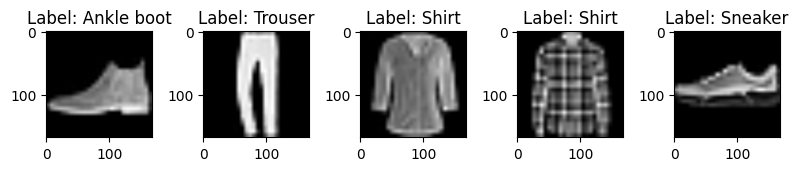

In [9]:
#### Print a few of the test data images

# Index of the images to plot (within the batch)
iix = [0,2,4,7,9]

plt.figure(figsize=(8, 8))  # Set a larger figure size

for i,ix in enumerate(iix):
    # Plot images
    plt.subplot(1,len(iix), i+1)
    plt.imshow(ex_images[ix])
    plt.title(f"Label: {class_names[ex_labels[ix]]}")

plt.tight_layout()
plt.show()

# Transfer learning
Now follows the main topic of this exercise.

## Read in the model to transfer
You can find the available models at [Keras Applications](https://keras.io/api/applications/)

For this excersize you will use [VGG16](https://keras.io/api/applications/vgg/#vgg16-function).

When loading VGG, you must choose the correct values of some of the input parameters:
* weights='imagenet' --- Since we want to use the weights pretrained on the imagenet
* include_top=False --- This is False, we anyway will replace the "top" with our own layers. Note that they call the layers closest to the output the top layers.
* input_shape= **???** --- Set it to the same shape as the pictures have!

### Uppgift
Om du tittar på sidan för [VGG16](https://keras.io/api/applications/vgg/#vgg16-function), vilken är den minsta möjliga bildstorlek?

**Svar:** 32x32

In [10]:

##################### TODO: YOUR CODE STARTS HERE #####################
#### Read in the model to transfer
tl_model = keras.applications.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(NEWIMG_HEIGHT, NEWIMG_WIDTH, 3))

# For now we are not training the parameters in the transfered model
tl_model.trainable = False
##################### TODO: YOUR CODE ENDS HERE #######################
tl_model.summary(show_trainable=True)

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 168, 168, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 168, 168, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 168, 168, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 84, 84, 64)        0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 84, 84, 128)       73856     N          
                                                                         

### Uppgift
Hur många parametrar finns i VGG16?

**Svar:** 14,714,688

**Analysera VGG-modellens lager**

Eftersom Fashion MNIST-bilderna är mycket små (28x28 original men inte mycket större efter skalning) kan vi inte effektivt använda hela modellen, eftersom den innehåller så många lager att de senare faltningslagren degenererar. Detta kan observeras i kolumnen Output Shape i model.summary. Där vi ser att lager på slutet får en "bildstorlek" som är av samma storlek som faltningskärnorna.

### Uppgift
Om du tittar på VGGs `model.summary` ovan, vid vilket lager kan det vara lämpligt att stanna? Notera detta kommer att bero på hur mycket du skalat upp inbilden. Det kommer också delvis bero på hur dina egna lager ser ut, som om du t.ex. vill ha ett eget faltningslager eller om du kanske direkt vill platta till modellen och bara köra kompakta lager.)

**Svar:** Fick bra resultat när jag slutade på "block3_pool". fick 0.916

In [13]:
##################### TODO: CHANGE!
name_of_last_TL_layer = 'block3_pool'

## Build a transfered model

In [14]:
#### Build our own layers on top of the transfered model (use a functional definition as this is easier)

# Step 1. Get an output tensor of the last transfer-model layer that we want to include
x = tl_model.get_layer(name_of_last_TL_layer).output

##################### TODO: YOUR CODE STARTS HERE #####################
# Step 2. Stack our own layers on top
x = keras.layers.BatchNormalization(axis=-1)(x)
##### more layers

x = keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(None, NEWIMG_WIDTH, NEWIMG_HEIGHT, 3))(x)
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(None, NEWIMG_WIDTH, NEWIMG_HEIGHT, 3))(x)

x = keras.layers.Flatten()(x)
##### more layers
x = keras.layers.Dense(36, activation='relu')(x)
##################### TODO: YOUR CODE ENDS HERE #######################
x = keras.layers.Dense(10, activation='softmax')(x)

# Creating new combined model. Note that this is NOT a Sequential() model.
model = keras.models.Model(inputs=tl_model.input, outputs=x)

print(model.summary(show_trainable=True))

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 168, 168, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 168, 168, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 168, 168, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 84, 84, 64)        0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 84, 84, 128)       73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 84, 84, 128)       1475

### Uppgift
Hur många träningsbara parametrar finns i din överförda modell?

**Svar:** 359670

In [15]:
#### Compile the model (note SparseCategoricalCrossentropy as we have not converted labels)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.3e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [16]:
#### Training the model
# batch_size = 32 # Now set in datastream
epochs = 10

# Set callback functions to early stop training and save the best model so far
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3,restore_best_weights = True)]

start = time.perf_counter()
history = model.fit(train_ds,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=val_ds,
                    callbacks=callbacks)
end = time.perf_counter()
print(f"Time to run: {end - start:.2f}s",)

Epoch 1/10
375/375 [==============================] - 112s 263ms/step - loss: 0.3588 - acc: 0.8746 - val_loss: 0.2541 - val_acc: 0.9100
Epoch 2/10
375/375 [==============================] - 102s 272ms/step - loss: 0.2034 - acc: 0.9295 - val_loss: 0.2374 - val_acc: 0.9180
Epoch 3/10
375/375 [==============================] - 103s 275ms/step - loss: 0.1520 - acc: 0.9481 - val_loss: 0.2279 - val_acc: 0.9209
Epoch 4/10
375/375 [==============================] - 102s 272ms/step - loss: 0.1153 - acc: 0.9615 - val_loss: 0.2361 - val_acc: 0.9215
Epoch 5/10
375/375 [==============================] - 102s 272ms/step - loss: 0.0906 - acc: 0.9695 - val_loss: 0.2487 - val_acc: 0.9231
Epoch 6/10
375/375 [==============================] - 103s 275ms/step - loss: 0.0830 - acc: 0.9698 - val_loss: 0.3071 - val_acc: 0.9142
Epoch 6: early stopping
Time to run: 703.23s


In [17]:
# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.3f}')

78/78 [==============================] - 16s 209ms/step - loss: 0.2363 - acc: 0.9160
Test accuracy: 0.916


## Uppgift
Notera antal parametrar som tränats, testnoggrannhet, körtid
(Notera att en noggrannhet på 91.5% är minimum för denna laboration!)

Vad kan man dra för slutsatser av dina körningar i denna del? \
**Svar:** Hade 359670 träningsbara parametrar, fick en testnoggrannhet på 0.916 (91.6%) och en körtid på 703.23s. \
Om jag inte haft VGG16-modellen skulle mina resultat med samma topplager ha varit betydligt sämre.

## Uppgift
När du nu funnit de bästa "topplagren" du kan finna, utvärdera din överförda model även med följande variationer:
* bildstorlek: utvärdera med följande bildstorlekar: minimistorlek, 28\*2x28\*2,  28\*3x28\*3.

Notera antal parametrar som tränats, testnoggrannhet, körtid

Vad kan man dra för slutsatser av detta?


In [18]:

##################### TODO: YOUR CODE STARTS HERE #####################
#### Read in the model to transfer
tl_model = keras.applications.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(NEWIMG_HEIGHT, NEWIMG_WIDTH, 3))

# For now we are not training the parameters in the transfered model
tl_model.trainable = True
##################### TODO: YOUR CODE ENDS HERE #######################
tl_model.summary(show_trainable=True)

Model: "vgg16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 168, 168, 3)]     0         Y          
                                                                            
 block1_conv1 (Conv2D)       (None, 168, 168, 64)      1792      Y          
                                                                            
 block1_conv2 (Conv2D)       (None, 168, 168, 64)      36928     Y          
                                                                            
 block1_pool (MaxPooling2D)  (None, 84, 84, 64)        0         Y          
                                                                            
 block2_conv1 (Conv2D)       (None, 84, 84, 128)       73856     Y          
                                                                            
 block2_conv2 (Conv2D)       (None, 84, 84, 128)       147584

In [19]:
##################### TODO: CHANGE!
name_of_last_TL_layer = 'block3_pool'

In [20]:
#### Build our own layers on top of the transfered model (use a functional definition as this is easier)

# Step 1. Get an output tensor of the last transfer-model layer that we want to include
x = tl_model.get_layer(name_of_last_TL_layer).output

##################### TODO: YOUR CODE STARTS HERE #####################
# Step 2. Stack our own layers on top
x = keras.layers.BatchNormalization(axis=-1)(x)
##### more layers

x = keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(None, NEWIMG_WIDTH, NEWIMG_HEIGHT, 3))(x)
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(None, NEWIMG_WIDTH, NEWIMG_HEIGHT, 3))(x)

x = keras.layers.Flatten()(x)
##### more layers
x = keras.layers.Dense(36, activation='relu')(x)
##################### TODO: YOUR CODE ENDS HERE #######################
x = keras.layers.Dense(10, activation='softmax')(x)

# Creating new combined model. Note that this is NOT a Sequential() model.
model = keras.models.Model(inputs=tl_model.input, outputs=x)

print(model.summary(show_trainable=True))

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 168, 168, 3)]     0         Y          
                                                                            
 block1_conv1 (Conv2D)       (None, 168, 168, 64)      1792      Y          
                                                                            
 block1_conv2 (Conv2D)       (None, 168, 168, 64)      36928     Y          
                                                                            
 block1_pool (MaxPooling2D)  (None, 84, 84, 64)        0         Y          
                                                                            
 block2_conv1 (Conv2D)       (None, 84, 84, 128)       73856     Y          
                                                                            
 block2_conv2 (Conv2D)       (None, 84, 84, 128)       1475

In [21]:
#### Compile the model (note SparseCategoricalCrossentropy as we have not converted labels)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [1]:
#### Training the model
# batch_size = 32 # Now set in datastream
epochs = 10

# Set callback functions to early stop training and save the best model so far
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3,restore_best_weights = True)]

start = time.perf_counter()
history = model.fit(train_ds,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=val_ds,
                    callbacks=callbacks)
end = time.perf_counter()
print(f"Time to run: {end - start:.2f}s",)

NameError: name 'keras' is not defined

# Del B

För överförd inlärning med VGG enligt ovan så ska du här slå på träning även för några av de importerade lagren och utvärdera hur det påverkar modellens prestanda. Lämpligen slår du först på alla lager för träning: "model.trainable = True". Om du sedan inte vill träna alla lager så kan du loopa över alla lager och göra "layer.trainable = False" där/om så behövs.
Notera att du kan lätt se vilka lager som är träningsbara mha `model.summary(show_trainable=True)`

Notera att du nog bör minska inlärningstakten (till typ 1e-4 -- 1e-5 för Adam) när du även tränar den överförda modellens parametrar, för annars kan den "glömma" för mycket av den förtränade modellen och modellen kan rent av bli sämre.

# Del X (VG uppgift)

För denna deluppgift ska du ersätta VGG16 med Xception https://keras.io/api/applications/xception/ som bas för överförd inlärning och utvärdera den resulterande modellen på vårt Fashion-MNIST problem. Notera att Xception har en annan storlek som minsta möjliga storlek för inbilderna. Då modellen har 126 lager så kommer vi bara använda en del av alla dess lager på våra små bilder. Välj ett lämplig antal lager av Xceptionmodellen och motivera varför du inte använder fler. Utvärdera Xception och jämför med när du använde VGG16.

# För Alla Delar
Samanställ dina resultat och gör en analys om hur de olika modellerna beter sig, speciellt mellan de modeller du har prövat i denna laboration, men även mot dina resultat i Laboration 1.